<a href="https://colab.research.google.com/github/keduog/LLM/blob/main/Copy_of_Hilko_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

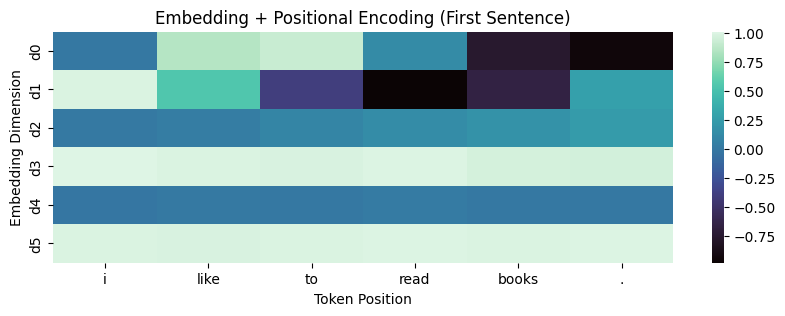

In [ ]:
# Step 4: Embedding Layer + Positional Encoding
seq_len = input_tensor.size(1)
dim = 6  # Embedding dimension
vocab_size = tokenizer.vocab_size

# Define embedding layer
embedding = nn.Embedding(vocab_size, dim)
nn.init.xavier_uniform_(embedding.weight)

# Get embedded tokens
embedded_input = embedding(input_tensor)  # shape: [batch_size, seq_len, dim]

# Positional Encoding (sinusoidal, fixed)
def get_positional_encoding(seq_len, dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
    angle_rads = pos * angle_rates

    # apply sin to even indices in the array; cos to odd indices
    pos_encoding = np.zeros_like(angle_rads)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return torch.tensor(pos_encoding, dtype=torch.float)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_len, dim)  # [seq_len, dim]
embedded_input += pos_encoding.unsqueeze(0)  # broadcast over batch

# Visualize embeddings + position encoding for the first sentence
plt.figure(figsize=(10, 3))
sns.heatmap(embedded_input[0].detach().numpy().T, cmap="mako",
            xticklabels=tokenizer.convert_ids_to_tokens(input_tensor[0]), yticklabels=[f"d{i}" for i in range(dim)])
plt.title("Embedding + Positional Encoding (First Sentence)")
plt.xlabel("Token Position")
plt.ylabel("Embedding Dimension")
plt.show()


In [ ]:
# Step 5: Define One Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=1, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

        # Xavier Initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        attn_out, attn_weights = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x, attn_weights


In [ ]:
# Step 6: Stack 4 Layers
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, dim, num_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.encoder_layers = nn.ModuleList([TransformerEncoderBlock(dim) for _ in range(num_layers)])
        self.output_layer = nn.Linear(dim, vocab_size)

        # Init
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        x = self.embedding(x)
        seq_len = x.size(1)
        pos_encoding = get_positional_encoding(seq_len, x.size(2)).to(x.device)
        x = x + pos_encoding.unsqueeze(0)

        all_attn_weights = []
        for layer in self.encoder_layers:
            x, attn_weights = layer(x)
            all_attn_weights.append(attn_weights)

        logits = self.output_layer(x)
        return logits, all_attn_weights


In [ ]:
# Step 6: Stack 4 Layers
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, dim, num_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.encoder_layers = nn.ModuleList([TransformerEncoderBlock(dim) for _ in range(num_layers)])
        self.output_layer = nn.Linear(dim, vocab_size)

        # Init
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        x = self.embedding(x)
        seq_len = x.size(1)
        pos_encoding = get_positional_encoding(seq_len, x.size(2)).to(x.device)
        x = x + pos_encoding.unsqueeze(0)

        all_attn_weights = []
        for layer in self.encoder_layers:
            x, attn_weights = layer(x)
            all_attn_weights.append(attn_weights)

        logits = self.output_layer(x)
        return logits, all_attn_weights


In [ ]:
# Step 7: Instantiate Model
model = SimpleTransformer(vocab_size=vocab_size, dim=dim, num_layers=4)


In [ ]:
# Step 8: Select a sentence to visualize
sentence = "I like to read books."
tokens = tokenizer.encode(sentence, add_special_tokens=False)
input_ids = torch.tensor(tokens).unsqueeze(0)

# Get token strings
token_strings = tokenizer.convert_ids_to_tokens(tokens)

# Forward pass through model
model.eval()
with torch.no_grad():
    logits, attn_weights = model(input_ids)


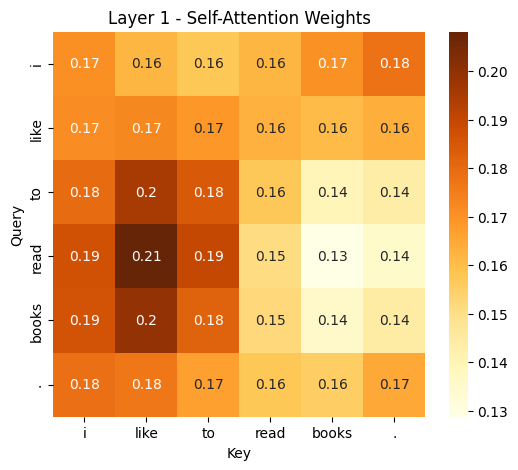

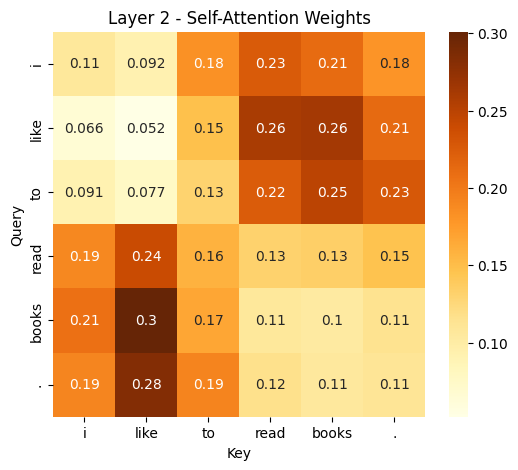

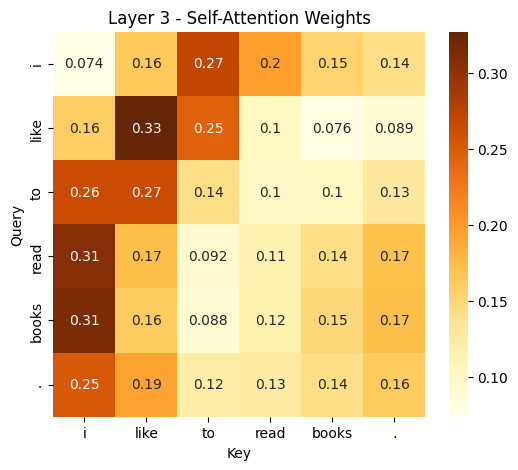

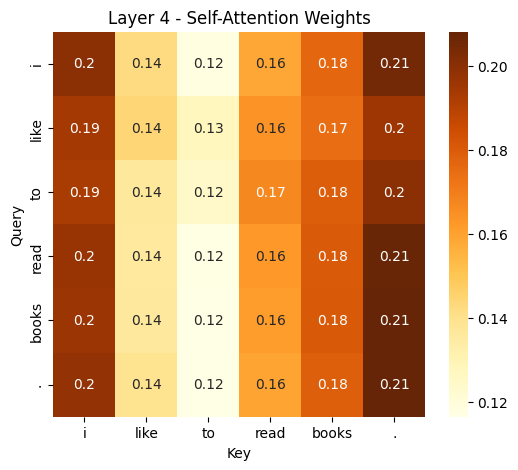

In [ ]:
# Step 9: Plot attention weights per layer
for layer_idx, attn in enumerate(attn_weights):
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn[0].detach().numpy(), annot=True, cmap="YlOrBr",
                xticklabels=token_strings, yticklabels=token_strings)
    plt.title(f"Layer {layer_idx+1} - Self-Attention Weights")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


In [ ]:
# Step 10: Prepare training inputs and targets
tokenized = [tokenizer.encode(s, add_special_tokens=False) for s in training_sentences]

# Remove short sequences
tokenized = [ids for ids in tokenized if len(ids) > 1]

# Prepare input-output pairs
input_seqs = [torch.tensor(ids[:-1]) for ids in tokenized]
target_seqs = [torch.tensor(ids[1:]) for ids in tokenized]

# Use padding to equal length
max_len = max(len(seq) for seq in input_seqs)
pad_id = tokenizer.pad_token_id

def pad(seq, length):
    return torch.cat([seq, torch.full((length - len(seq),), pad_id)])

input_tensor = torch.stack([pad(seq, max_len) for seq in input_seqs])
target_tensor = torch.stack([pad(seq, max_len) for seq in target_seqs])


In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Store weight updates for visualization
weight_updates = []

# Train one sentence at a time for interpretability
for step in range(len(input_tensor)):
    inp = input_tensor[step].unsqueeze(0)
    tgt = target_tensor[step].unsqueeze(0)

    model.train()
    optimizer.zero_grad()

    # Save weight before update
    old_weight = model.output_layer.weight.detach().clone()

    logits, _ = model(inp)
    loss = loss_fn(logits.view(-1, vocab_size), tgt.view(-1))
    loss.backward()
    optimizer.step()

    # Calculate weight diff
    with torch.no_grad():
        diff = model.output_layer.weight - old_weight
        weight_updates.append(diff.detach().cpu().numpy())

    print(f"Sentence {step+1} → Loss: {loss.item():.4f}")


Sentence 1 → Loss: 10.3169
Sentence 2 → Loss: 10.3010
Sentence 3 → Loss: 10.2481
Sentence 4 → Loss: 10.2195
Sentence 5 → Loss: 10.1846
Sentence 6 → Loss: 10.1249
Sentence 7 → Loss: 10.0277
Sentence 8 → Loss: 10.0828
Sentence 9 → Loss: 9.9027
Sentence 10 → Loss: 9.8364


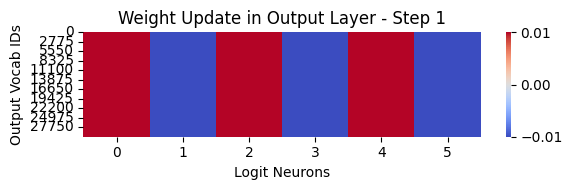

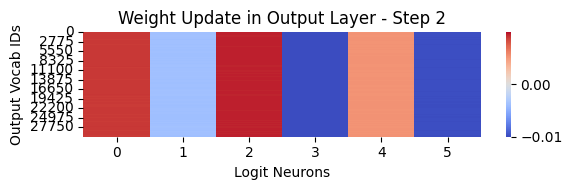

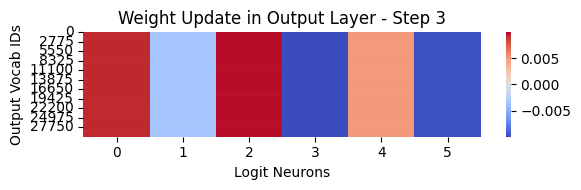

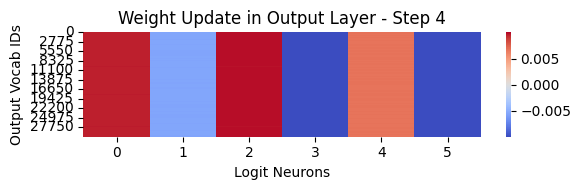

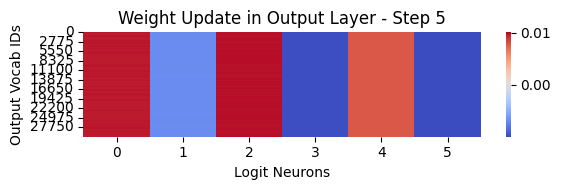

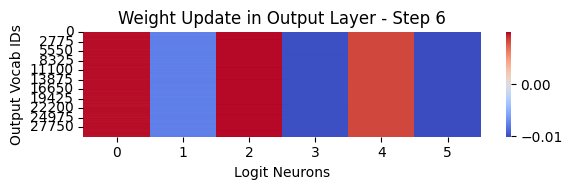

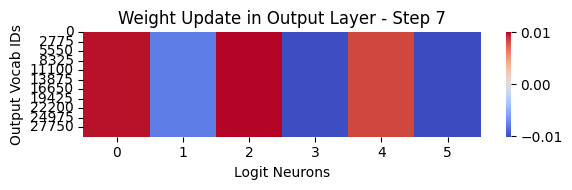

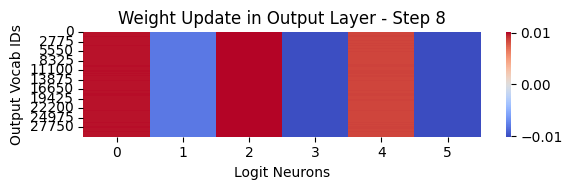

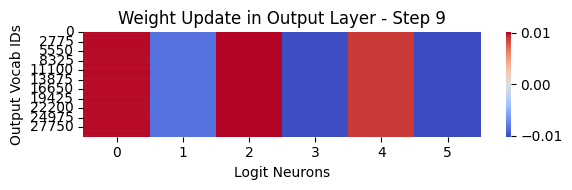

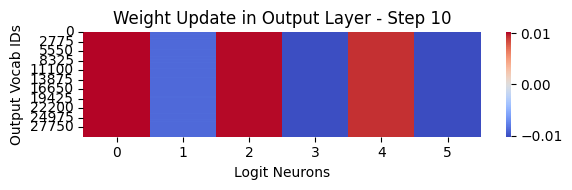

In [ ]:
# Visualize weight changes after each sentence
for i, diff in enumerate(weight_updates):
    plt.figure(figsize=(6, 2))
    sns.heatmap(diff, cmap="coolwarm", center=0)
    plt.title(f"Weight Update in Output Layer - Step {i+1}")
    plt.xlabel("Logit Neurons")
    plt.ylabel("Output Vocab IDs")
    plt.tight_layout()
    plt.show()


In [ ]:
# Step 13: Provide a test input sentence
test_sentence = "The dog is"

# Tokenize (no special tokens)
test_ids = tokenizer.encode(test_sentence, add_special_tokens=False)
input_ids = torch.tensor(test_ids).unsqueeze(0)

# Show tokens
tokens = tokenizer.convert_ids_to_tokens(test_ids)
print(f"Input tokens: {tokens}")


Input tokens: ['the', 'dog', 'is']


In [ ]:
model.eval()
with torch.no_grad():
    logits, attn_weights = model(input_ids)


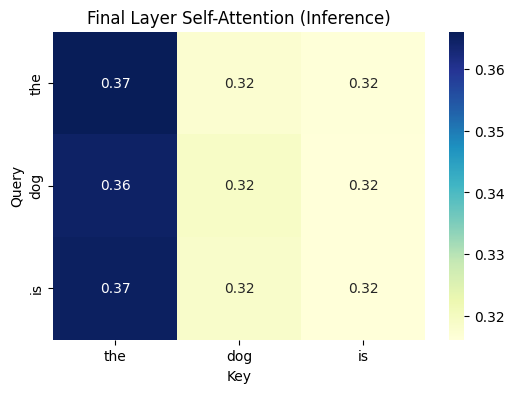

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(attn_weights[-1][0].detach().numpy(), annot=True, cmap="YlGnBu",
            xticklabels=tokens, yticklabels=tokens)
plt.title("Final Layer Self-Attention (Inference)")
plt.xlabel("Key"); plt.ylabel("Query")
plt.show()


In [ ]:
# Take the last token's output
last_logits = logits[0, -1]
topk = torch.topk(last_logits, 5)
top_ids = topk.indices.tolist()
top_scores = topk.values.tolist()

# Show prediction
print("Top 5 predicted next tokens:")
for i, (tid, score) in enumerate(zip(top_ids, top_scores)):
    print(f"{i+1}. {tokenizer.convert_ids_to_tokens([tid])[0]} (score: {score:.2f})")


Top 5 predicted next tokens:
1. . (score: 0.73)
2. to (score: 0.42)
3. read (score: 0.35)
4. like (score: 0.34)
5. books (score: 0.33)


In [ ]:
# Utility: Predict next token given a trained model and input sentence
def predict_next_token(model, sentence, tokenizer, top_k=5):
    model.eval()
    with torch.no_grad():
        # Tokenize input
        ids = tokenizer.encode(sentence, add_special_tokens=False)
        input_ids = torch.tensor(ids).unsqueeze(0)  # [1, seq_len]

        # Run through model
        logits, attn_weights = model(input_ids)

        # Get last token's output
        final_logits = logits[0, -1]
        top = torch.topk(final_logits, top_k)
        top_ids = top.indices.tolist()
        top_scores = top.values.tolist()

        print(f"\nInput: \"{sentence}\"")
        print("Predicted next token(s):")
        for i, (tid, score) in enumerate(zip(top_ids, top_scores)):
            token = tokenizer.convert_ids_to_tokens([tid])[0]
            print(f"{i+1}. {token} (score: {score:.2f})")


In [ ]:
predict_next_token(model, "Birds are flying.", tokenizer)



Input: "Birds are flying."
Predicted next token(s):
1. . (score: 0.73)
2. to (score: 0.42)
3. read (score: 0.35)
4. like (score: 0.34)
5. books (score: 0.33)
